# Titanic Dataset: Predicting Survival <br>

# 1. What is the big picture?
<br>

- I am given the data of passengers on the historical ship, the Titanic. My goal is to predict whether the passenger survived or not based on features like age, gender, class, etc.

- This is a learning/for-fun project and I just want to have high accuracy when predicting on the test set.

- This is a supervised-learning problem because I am given the target labels for the training set - whether they survived or not. 

- This is also a binary classification problem because the target feature can be one of two categories - negative (dead) and positive (survived). 

- I will be using batch or offline learning because the dataset cannot be updated (it's like 100 years old after all) and the dataset is not large. 

- I will also be using model-based learning because I have not learned instance-based learning yet.

- The performance measure is accuracy. I don't have to consider precision-recall tradeoff because I just want to be as accurate as possible.

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the models and scores
import joblib
PROJECT_ROOT_DIR = "."
PROJECT_ID = "titanic"
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "_models", PROJECT_ID)
os.makedirs(MODELS_PATH, exist_ok=True)

# Save models, cross-val accuracy scores, cross-val predictions, and pipelines
def save_model(model, model_id):
    path = os.path.join(MODELS_PATH, model_id + ".pkl")
    print("Saving model", model_id)
    joblib.dump(model, path)

def load_model(model_id):
    path = os.path.join(MODELS_PATH, model_id + ".pkl")
    return joblib.load(path)

# 2. Get the Data

In [3]:
import pandas as pd

TITANIC_PATH = os.path.join(PROJECT_ROOT_DIR, "_datasets", PROJECT_ID)

def load_data(titanic_path=TITANIC_PATH):
    train = pd.read_csv(os.path.join(titanic_path, "train.csv"))
    test = pd.read_csv(os.path.join(titanic_path, "test.csv"))
    return train, test

In [4]:
train, test = load_data()

- Don't touch the test set till we've finalized our model

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train.columns[train.isnull().any()]

Index(['Age', 'Cabin', 'Embarked'], dtype='object')

In [10]:
train.select_dtypes(include=object).columns

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

In [12]:
train.select_dtypes(include=np.number).columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

- Features with **missing** data
    - `'Age', 'Cabin', 'Embarked'`
- Features with **text** data
    - `'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'`
- Features with **numerical** data
    - `'PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'`

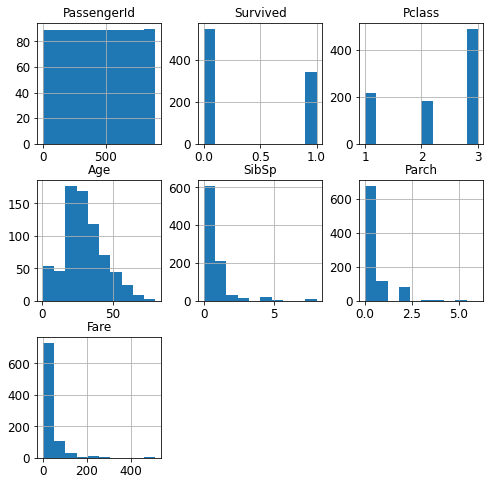

In [19]:
train.hist(bins=10, figsize=(8,8))
plt.show()

- PassengerId seems to have no pattern to its distribution.
    - most likely a useless feature
- Pclass is **categorical**
- There is a lot of skew towards the right in Age, SibSp, Parch, and Fare

In [24]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

- There is an uneven distribution, but inuitively this feature would not have any effect
    - We may need to tune how many features used as a parameter later

# 3. Visualize and Explore the Data
<br>

In [43]:
X_train = train.drop('Survived', axis=1)
y_train = train['Survived'].copy()

## How to Deal With Missing Values

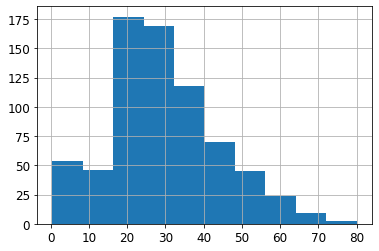

In [45]:
missing_features = ['Age', 'Cabin', 'Embarked']

X_train['Age'].hist()
plt.show()

- This has a right-skewed distribution
    - we may want to use 'median' as the imputing strategy

In [46]:
X_train['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

- The data may be useful, but median imputing strategy may not work, given that there are only 204 non-null values the best strategy may be to abandon this feature

In [47]:
X_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [48]:
X_train[X_train['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


<AxesSubplot:xlabel='Embarked', ylabel='count'>

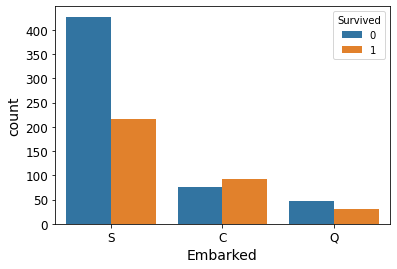

In [53]:
import seaborn as sns

# use train for plotting
sns.countplot(x='Embarked', hue='Survived', data=train)